# Data Loading

In [1]:
import glob
import numpy as np

# Get all npy files
files = glob.glob("HR_Tiled_HSI/*.npy")
gt_arrays = []
for file in files:
    x = np.load(file)
    y = []
    for i in range(0, 40):
        y.append(x[i])
    y = np.dstack(y)
    gt_arrays.append(y)
gt_imgs = np.array(gt_arrays)

# Load other arrays
lrhsi_files = glob.glob("HR_Tiled_HSI/*.npy")
lrhsi_arrays = []
for file in lrhsi_files:
    x = np.load(file)
    y = []
    for i in range(0, 40):
        y.append(x[i])
    y = np.dstack(y)
    lrhsi_arrays.append(y)
lrhsi_imgs = np.array(lrhsi_arrays)

# Load BGR images
hrmsi_files = glob.glob("Downsampled_Tiled_HR_BGR/*.npy")
hrmsi_arrays = []
for file in hrmsi_files:
    x = np.load(file)
    y = []
    for i in range(x.shape[0]):
        y.append(x[i])
    y = np.dstack(y)
    hrmsi_arrays.append(y)
hrmsi_imgs = np.array(hrmsi_arrays)

KeyboardInterrupt: 

In [ ]:
print(hrmsi_imgs[0].shape)
print(gt_imgs[0].shape)
print(lrhsi_imgs[0].shape)

# Model

## Model Macro Parameters

In [1]:
# Model params
NUM_IMAGES = 144
IMAGE_SIZE_MSI = 320
IMAGE_SIZE_HSI = 64

FACTOR = 5 

NUM_BANDS = 40

## Model Architecture Definition

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, initializers
from keras.regularizers import l2
from keras.initializers import VarianceScaling
from keras.initializers import RandomNormal
from keras.initializers import GlorotUniform

def downsample(x):
    return layers.Conv2D(
        filters=3,
        kernel_size=6,
        strides=FACTOR,
        activation="sigmoid",
        kernel_regularizer=l2(1e-4),
        kernel_initializer=VarianceScaling(),
        padding="SAME",
    )(x)


def upsample(x):
    return layers.UpSampling2D(size=(FACTOR, FACTOR))(x)


def channel_attention(x):
    gap = layers.GlobalAveragePooling2D()(x)
    gap = layers.Reshape((1, 1, NUM_BANDS))(gap)
    ca = layers.Conv2D(
        filters=1,
        kernel_size=1,
        activation=tf.keras.layers.LeakyReLU(),
        kernel_regularizer=l2(1e-4),
        kernel_initializer=VarianceScaling(),
        padding="SAME",
    )(gap)
    ca = layers.Conv2D(
        filters=NUM_BANDS,
        kernel_size=1,
        activation="sigmoid",
        kernel_regularizer=l2(1e-4),
        kernel_initializer=GlorotUniform(),
        padding="SAME",
    )(ca)
    return ca


def spatial_attention(x):
    sa = layers.Conv2D(
        filters=1,
        kernel_size=2,
        activation="sigmoid",
        kernel_regularizer=l2(1e-4),
        kernel_initializer=VarianceScaling(),
        padding="SAME",
    )(x)
    sa = layers.Conv2D(
        filters=1,
        kernel_size=3,
        activation="sigmoid",
        kernel_regularizer=l2(1e-4),
        kernel_initializer=VarianceScaling(),
        padding="SAME",
    )(sa)
    sa = layers.Conv2D(
        filters=1,
        kernel_size=4,
        activation="sigmoid",
        kernel_regularizer=l2(1e-4),
        kernel_initializer=VarianceScaling(),
        padding="SAME",
    )(sa)
    sa = layers.Conv2D(
        filters=1,
        kernel_size=5,
        activation="sigmoid",
        kernel_regularizer=l2(1e-4),
        kernel_initializer=VarianceScaling(),
        padding="SAME",
    )(sa)
    sa = layers.Conv2D(
        filters=1,
        kernel_size=6,
        activation="sigmoid",
        kernel_regularizer=l2(1e-4),
        kernel_initializer=VarianceScaling(),
        padding="SAME",
    )(sa)
    sa = layers.Conv2D(
        filters=1,
        kernel_size=5,
        activation="sigmoid",
        kernel_regularizer=l2(1e-4),
        kernel_initializer=VarianceScaling(),
        padding="SAME",
    )(sa)
    sa = layers.Conv2D(
        filters=1,
        kernel_size=4,
        activation="sigmoid",
        kernel_regularizer=l2(1e-4),
        kernel_initializer=VarianceScaling(),
        padding="SAME",
    )(sa)
    sa = layers.Conv2D(
        filters=1,
        kernel_size=3,
        activation="sigmoid",
        kernel_regularizer=l2(1e-4),
        kernel_initializer=VarianceScaling(),
        padding="SAME",
    )(sa)
    sa = layers.Conv2D(
        filters=1,
        kernel_size=2,
        activation="sigmoid",
        kernel_regularizer=l2(1e-4),
        kernel_initializer=VarianceScaling(),
        padding="SAME",
    )(sa)

    return sa

def squeeze_excite_block(input_tensor, hsi, ratio=4):

    channels = input_tensor.shape[-1]
    
    # Squeeze operation
    squeeze = layers.GlobalAveragePooling2D()(hsi)
    
    # Excitation operation
    excitation = layers.Dense(channels // ratio, activation='relu', kernel_initializer=VarianceScaling())(squeeze)
    excitation = layers.Dense(channels, activation='sigmoid', kernel_initializer=GlorotUniform())(excitation)
    
    # Scale the input tensor
    output_tensor = layers.multiply([input_tensor, excitation])
    
    return output_tensor


def _phase_shift(x, r):
    bsize, h, w, c = x.get_shape().as_list()
    bsize = tf.shape(x)[0]
    x = tf.reshape(x, shape=[bsize, h, w, r, r])
    x = tf.split(x, h, axis=1)
    x = tf.concat([tf.squeeze(x_, axis=1) for x_ in x], axis=2)
    x = tf.split(x, w, axis=1)
    x = tf.concat([tf.squeeze(x_, axis=1) for x_ in x], axis=2)
    return tf.reshape(x, shape=[bsize, h * r, w * r, 1])


def pixel_shuffle(x, r):
    x_split = tf.split(x, NUM_BANDS, axis=3)
    x = tf.concat([_phase_shift(x_, r) for x_ in x_split], axis=3)
    return x


def HSRnet(inputs):
    lrhsi, hrmsi = inputs

    hrmsi_down = downsample(hrmsi)
    lrhsi_up = upsample(lrhsi)

    merged = layers.Concatenate()([hrmsi_down, lrhsi])

    c1 = layers.Conv2D(
        filters=NUM_BANDS * FACTOR * FACTOR,
        kernel_size=3,
        activation=tf.keras.layers.LeakyReLU(),
        kernel_regularizer=l2(1e-4),
        kernel_initializer=VarianceScaling(),
        padding="SAME",
    )(merged)

    c1 = pixel_shuffle(c1, FACTOR)

    rslice, gslice, bslice = tf.split(hrmsi, 3, axis=-1)
    msp1, msp2 = tf.split(c1, [20, 20], axis=-1)
    merged2 = layers.Concatenate(axis=-1)([bslice, msp1, gslice, msp2, rslice])
    first_two_bands = merged2[..., :2]
    last_two_bands = merged2[..., -2:]
    average_first_two_bands = tf.reduce_mean(first_two_bands, axis=-1, keepdims=True)
    average_last_two_bands = tf.reduce_mean(last_two_bands, axis=-1, keepdims=True)
    middle_bands = merged2[..., 2:-3]
    merged2 = tf.keras.layers.Concatenate(axis=-1)(
        [average_first_two_bands, middle_bands, average_last_two_bands]
    )

    for i in range(12):
        res = layers.Conv2D(
            filters=NUM_BANDS,
            kernel_size=3,
            activation=tf.keras.layers.LeakyReLU(),
            kernel_regularizer=l2(1e-4),
            kernel_initializer=VarianceScaling(),
            padding="SAME",
        )(merged2)
        res = layers.Conv2D(
            filters=NUM_BANDS,
            kernel_size=3,
            kernel_regularizer=l2(1e-4),
            kernel_initializer=VarianceScaling(),
            padding="SAME",
        )(res)
        merged2 = layers.add([merged2, res])
        #merged2 = squeeze_excite_block(merged2,lrhsi_up)

    sa = spatial_attention(hrmsi)
    merged2 = layers.multiply([merged2, sa])

    out = layers.Conv2D(
        filters=NUM_BANDS,
        kernel_size=3,
        kernel_regularizer=l2(1e-4),
        kernel_initializer=VarianceScaling(),
        padding="SAME",
    )(merged2)

    ca = channel_attention(lrhsi_up)

    out = layers.multiply([out, ca])

    return out

2024-03-30 02:35:18.654259: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-30 02:35:18.673749: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 02:35:18.673771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 02:35:18.674287: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-30 02:35:18.677546: I tensorflow/core/platform/cpu_feature_guar

## Data Generator 

In [3]:
# Data generator function
import numpy as np

def data_generator(lrhsi_data, hrmsi_data, gt_hsi_data, gt_msi_data, batch_size):
    # Infinite loop
    while True:
        # Generate batch indexes
        indexes = np.random.randint(0, len(lrhsi_data), batch_size)

        # Generate data for this batch
        lrhsi_batch = lrhsi_data[indexes]
        hrmsi_batch = hrmsi_data[indexes]
        gt_hsi_batch = gt_hsi_data[indexes]
        gt_msi_batch = gt_msi_data[indexes]
        
        gt_hsi_batch = np.repeat(gt_hsi_batch, FACTOR, axis=1)
        gt_hsi_batch = np.repeat(gt_hsi_batch, FACTOR, axis=2)
        
        gt= np.concatenate((gt_hsi_batch,gt_msi_batch),axis=-1)
        # Yield the batch
        yield [lrhsi_batch, hrmsi_batch], gt

## Custom Loss Function

In [4]:
import numpy as np
import tensorflow as tf
from numpy import ceil
from tensorflow.keras import layers

def gaussian_blur(img, kernel_size=11, sigma=5):
    def gauss_kernel(channels, kernel_size, sigma):
        ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel

    gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]

    return tf.nn.depthwise_conv2d(img, gaussian_kernel, [1, 1, 1, 1],
                                  padding='SAME', data_format='NHWC')

def downsampler(image, kernel_size=5, sigma=3.5):
    # Blur the image
    blurred_image = gaussian_blur(image, kernel_size, sigma)

    # Resize the blurred image
    downsampled_image = tf.image.resize(image, [IMAGE_SIZE_HSI, IMAGE_SIZE_HSI])

    return downsampled_image

def psnr(GT, P, max_val=255.):

  with tf.name_scope('PSNR'):

    mse = tf.reduce_mean(tf.abs(P - GT) ** 2) 

    return (10. * tf.math.log(max_val ** 2 / mse) / tf.math.log(10.))
  
# SSIM helper functions
def _ssim_helper(x, y, xy, c, mode):
  return tf.reduce_mean(tf.nn.conv2d(xy, _fspecial_gauss(11, 1.5), 
				    strides=[1,1,1,1], padding=mode) - c, 
			axis=[1,2,3])

def _fspecial_gauss(filter_size, sigma):
  # Function to mimic the 'fspecial' gaussian MATLAB function
  x_data, y_data = np.mgrid[-filter_size//2 + 1:filter_size//2 + 1, 
                           -filter_size//2 + 1:filter_size//2 + 1]

  x_data = np.expand_dims(x_data, axis=-1)
  x_data = np.expand_dims(x_data, axis=-1)

  y_data = np.expand_dims(y_data, axis=-1)
  y_data = np.expand_dims(y_data, axis=-1)

  x = tf.constant(x_data, dtype=tf.float32)
  y = tf.constant(y_data, dtype=tf.float32)

  g = tf.exp(-((x**2 + y**2)/(2.0*sigma**2)))
  return g / tf.reduce_sum(g)

def ssim(GT, P, max_val=255., filter_size=11, 
        filter_sigma=1.5, k1=0.01, k2=0.03):

  with tf.name_scope('SSIM'):

    C1 = (k1 * max_val) ** 2
    C2 = (k2 * max_val) ** 2

    mu1 = tf.nn.conv2d(GT, _fspecial_gauss(filter_size, filter_sigma), 
                       strides=[1,1,1,1], padding='VALID')
    mu2 = tf.nn.conv2d(P, _fspecial_gauss(filter_size, filter_sigma),
                       strides=[1,1,1,1], padding='VALID')

    mu1_sq = mu1 * mu1
    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = _ssim_helper(GT, mu1, mu1_sq, C1, 'VALID')
    sigma2_sq = _ssim_helper(P, mu2, mu2_sq, C2, 'VALID')
    sigma12   = _ssim_helper(GT, P, mu1_mu2, C2, 'VALID')

    cs = (2 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)

    ssim = ((2 * mu1_mu2 + C1) / (mu1_sq + mu2_sq + C1)) * cs

  return tf.reduce_mean(ssim)


def sam(GT, P):
    with tf.name_scope('SAM'):
        
        # Reshape to (num_pixels, num_bands)
        GT = tf.reshape(GT, [-1, GT.shape[-1]]) 
        P = tf.reshape(P, [-1, P.shape[-1]])
        
        # Normalize vectors
        GT_norm = tf.nn.l2_normalize(GT, axis=1)
        P_norm = tf.nn.l2_normalize(P, axis=1)
        
        # Compute dot product
        dot = tf.reduce_sum(GT_norm * P_norm, axis=1, keepdims=True)
        
        # Clip values to [-1, 1] range
        dot = tf.clip_by_value(dot, -1.0, 1.0)
        
        # Compute angle
        angles = tf.acos(dot)
        
        return tf.reduce_mean(angles)
    
  
def similarity_penalty_per_band(y, y_pred):
    penalties = []
    for band_idx in range(y.shape[-1]):
        # Compute mean or standard deviation of pixel values for the current band in y
        mean_pixel_values_gt = tf.reduce_mean(y[:, :, :, band_idx])
        std_pixel_values_gt = tf.math.reduce_std(y[:, :, :, band_idx])
        
        # Use mean or standard deviation of the current band in y as the threshold for y_pred
        threshold_mean = tf.reduce_mean(mean_pixel_values_gt)
        threshold_std = tf.reduce_mean(std_pixel_values_gt)

        # Compute mean or standard deviation of pixel values for the current band in y_pred
        mean_pixel_values_pred = tf.reduce_mean(y_pred[:, :, :, band_idx])
        std_pixel_values_pred = tf.math.reduce_std(y_pred[:, :, :, band_idx])
        
        # Penalize if mean or standard deviation of y_pred is below the thresholds for this band
        penalty_mean = tf.reduce_mean(tf.maximum(0.0, threshold_mean - mean_pixel_values_pred))
        penalty_std = tf.reduce_mean(tf.maximum(0.0, threshold_std - std_pixel_values_pred))

        penalties.append(penalty_mean + penalty_std)

    return tf.reduce_sum(penalties)

def msid_loss(groundTruth, recovered):

    # Clip the input tensors to the range [0, 1]
    groundTruth = groundTruth / 255.0
    recovered = recovered / 255.0
    
    groundTruth = tf.clip_by_value(groundTruth, 0.0, 1.0)
    recovered = tf.clip_by_value(recovered, 0.0, 1.0)

    # Calculate the sum of spectral values for each pixel
    sumRC = tf.reduce_sum(recovered, axis=-1, keepdims=True)
    sumGT = tf.reduce_sum(groundTruth, axis=-1, keepdims=True)

    # Calculate logRC and logGT
    logRC = tf.math.log((recovered / (sumRC + 1e-15)) / (groundTruth / (sumGT + 1e-15)))
    logGT = tf.math.log((groundTruth / (sumGT + 1e-15)) / (recovered / (sumRC + 1e-15)))

    # Calculate the MSID loss for each pixel
    msid_pixel = tf.abs(tf.reduce_sum(recovered * logRC, axis=-1) +
                        tf.reduce_sum(groundTruth * logGT, axis=-1))

    # Calculate the mean MSID loss across all pixels
    msid_loss = tf.reduce_mean(msid_pixel)

    return msid_loss

def appsa_loss(groundTruth, recovered):

    # Normalize the input tensors to the range [0, 1]
    groundTruth = groundTruth / 255.0
    recovered = recovered / 255.0

    # Clip the input tensors to the range [0, 1]
    groundTruth = tf.clip_by_value(groundTruth, 0.0, 1.0)
    recovered = tf.clip_by_value(recovered, 0.0, 1.0)

    # Calculate the numerator
    nom = tf.reduce_sum(groundTruth * recovered, axis=-1)

    # Calculate the denominator
    denom = tf.norm(groundTruth, axis=-1) * tf.norm(recovered, axis=-1)

    # Calculate the cosine similarity
    cos = tf.where(nom / (denom + 1e-15) > 1, 1.0, nom / (denom + 1e-15))

    # Calculate the spectral angle
    appsa = tf.acos(cos)

    # Calculate the mean APPSA loss
    appsa_loss = tf.reduce_sum(appsa) / (tf.cast(tf.shape(groundTruth)[0] * tf.shape(groundTruth)[1], tf.float32))

    return appsa_loss

def cyclic_loss(y,y_pred):
  
  g1, g2 = tf.split(y, [NUM_BANDS, 3], axis=-1)
  g1 = tf.math.reduce_mean(g1, axis=[1,2], keepdims=True) 
  g_e=tf.image.resize(g1, [IMAGE_SIZE_HSI, IMAGE_SIZE_HSI], method='bilinear')

  generated_lr = downsampler(y_pred)
  
  predicted_grey=tf.reduce_mean(y_pred, axis=-1, keepdims=True)
  gtmsi_grey=tf.reduce_mean(g2, axis=-1, keepdims=True)

  ssim_1=tf.abs(1-ssim(gtmsi_grey,predicted_grey))

  '''
  
  psnr_1=psnr(gtmsi_grey,predicted_grey)
  

  sam_1=tf.abs(sam(g_e,generated_lr))
  psnr_2=psnr(g_e,generated_lr)
  appsa_=tf.abs(appsa_loss(g_e,generated_lr))

  # Calculate the MSID loss
  msid_loss_value = msid_loss(g_e, generated_lr)

  # Normalize or scale the MSID loss
  normalized_msid_loss = msid_loss_value / (tf.reduce_max(msid_loss_value) + 1e-8)

  penalty=tf.abs(similarity_penalty_per_band(g_e,generated_lr))

  '''

  reconstruction_loss = tf.reduce_mean(tf.abs(generated_lr - g_e))
  spatial_reconstruction_loss = tf.reduce_mean(tf.abs(predicted_grey - gtmsi_grey))
  
  total_loss = (reconstruction_loss*10) + (ssim_1*1000)  #+ (spatial_reconstruction_loss*10)+ (sam_1*10) - (psnr_2) +  (appsa_*10) # + (penalty)  - (psnr_1) 
  
  return total_loss

## Model Compilation

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.regularizers import l2

# Define the input layers for lrhsi and hrmsi
lrhsi_input = tf.keras.layers.Input(shape=(IMAGE_SIZE_HSI, IMAGE_SIZE_HSI, NUM_BANDS))
hrmsi_input = tf.keras.layers.Input(shape=(IMAGE_SIZE_MSI, IMAGE_SIZE_MSI, 3))

# Build the model
inputs = [lrhsi_input, hrmsi_input]
outputs = HSRnet(inputs)


model = models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer="adam",
    loss=cyclic_loss,
)

2024-03-30 02:35:19.944957: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-30 02:35:19.965101: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-30 02:35:19.965192: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Train, Test, Validation Split and Data Loading

In [ ]:
# Dataset size
num_samples = len(lrhsi_imgs)

# Train/val split
train_pct = 0.7
val_pct = 0.2

# Calculate splits
num_train = int(train_pct * num_samples)
num_val = int(val_pct * num_samples)

# Shuffle indexes
indexes = np.random.permutation(num_samples)

# Split indexes
train_indexes = indexes[:num_train]
val_indexes = indexes[num_train : num_train + num_val]
test_indexes = indexes[num_train + num_val :]

# Split data
train_lrhsi = lrhsi_imgs[train_indexes]
train_hrmsi = hrmsi_imgs[train_indexes]
train_gt = gt_imgs[train_indexes]

np.save("Train/train_lrhsi.npy", train_lrhsi)
np.save("Train/train_hrmsi.npy", train_hrmsi)
np.save("Train/train_gt.npy", train_gt)

val_lrhsi = lrhsi_imgs[val_indexes]
val_hrmsi = hrmsi_imgs[val_indexes]
val_gt = gt_imgs[val_indexes]

np.save("Val/val_lrhsi.npy", val_lrhsi)
np.save("Val/val_hrmsi.npy", val_hrmsi)
np.save("Val/val_gt.npy", val_gt)

test_lrhsi = lrhsi_imgs[test_indexes]
test_hrmsi = hrmsi_imgs[test_indexes]
test_gt = gt_imgs[test_indexes]

np.save("Test/test_lrhsi.npy", test_lrhsi)
np.save("Test/test_hrmsi.npy", test_hrmsi)
np.save("Test/test_gt.npy", test_gt)

batch_size = 1

In [6]:
import numpy as np

train_lrhsi = np.load("Train/train_lrhsi.npy")
train_hrmsi = np.load("Train/train_hrmsi.npy")
train_gt_hsi = np.load("Train/train_lrhsi.npy")
train_gt_msi = np.load("Train/train_hrmsi.npy")

val_lrhsi = np.load("Val/val_lrhsi.npy")
val_hrmsi = np.load("Val/val_hrmsi.npy")
val_gt_hsi = np.load("Val/val_lrhsi.npy")
val_gt_msi = np.load("Val/val_hrmsi.npy")

test_lrhsi = np.load("Test/test_lrhsi.npy")
test_hrmsi = np.load("Test/test_hrmsi.npy")
test_gt_hsi = np.load("Test/test_lrhsi.npy")
test_gt_msi = np.load("Test/test_hrmsi.npy")

## Model Training

In [ ]:
from keras.callbacks import ModelCheckpoint


batch_size = 10

train_generator = data_generator(train_lrhsi, train_hrmsi, train_gt_hsi, train_gt_msi, batch_size)
val_generator = data_generator(val_lrhsi, val_hrmsi, val_gt_hsi, val_gt_msi, batch_size)

checkpoint = ModelCheckpoint("models/HSR_Net_US2_1000e_{epoch:02d}.h5", save_freq=len(train_lrhsi) // batch_size)


training = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1000,
    steps_per_epoch=len(train_lrhsi) // batch_size,
    validation_steps=len(val_lrhsi) // batch_size,
    callbacks=[checkpoint],
)

In [ ]:
from keras.models import load_model
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

# Load model weights from last checkpoint
with tf.keras.utils.custom_object_scope({'cyclic_loss': cyclic_loss}):
    # Load the model with the custom loss function
    model = tf.keras.models.load_model("models/HSR_Net_US2_1000e_17.h5")


print("Checkpoint Loaded")

# Recreate generators
batch_size = 5
train_generator = data_generator(train_lrhsi, train_hrmsi, train_gt_hsi, train_gt_msi, batch_size)
val_generator = data_generator(val_lrhsi, val_hrmsi, val_gt_hsi, val_gt_msi, batch_size)

print("DataGen Remade")

checkpoint = ModelCheckpoint("models/HSR_Net_US2_1000e_{epoch:02d}.h5", save_freq=len(train_lrhsi) // batch_size)

# Train starting from last epoch
training = model.fit(
    train_generator,
    validation_data=val_generator,
    initial_epoch=17,
    epochs=1000,
    steps_per_epoch=len(train_lrhsi) // batch_size,
    validation_steps=len(val_lrhsi) // batch_size,
    callbacks=[checkpoint],
)

In [ ]:
import matplotlib.pyplot as plt


# Plot losses
plt.plot(training.history["loss"])
plt.plot(training.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

In [ ]:
model = load_model("models\HSR_Net9_p4_100e_91.h5")

In [ ]:
model.save("models\HSR_Net9_final_100e.h5")

# Test Set Predictions

In [ ]:
import numpy as np
import tensorflow as tf
import os

def cyclic_loss(lr,y_pred):
  pass

with tf.keras.utils.custom_object_scope({'cyclic_loss': cyclic_loss}):
    # Load the model with the custom loss function
    model = tf.keras.models.load_model("models/HSR_Net_US2_1000e_17.h5")

test_lrhsi = np.load("Test/test_lrhsi.npy")
test_hrmsi = np.load("Test/test_hrmsi.npy")

###################################################################################################################

test_lrhsi = test_lrhsi.reshape(-1, 64, 64, 40)
test_hrmsi = test_hrmsi.reshape(-1, 320, 320, 3)

# Create test output folder
test_output_dir = "test_outputs"
if not os.path.exists(test_output_dir):
    os.makedirs(test_output_dir)

# Testing loop
for i in range(len(test_lrhsi)):
    # Reshape inputs
    lrhsi = test_lrhsi[i].reshape(1, 64, 64, 40)
    hrmsi = test_hrmsi[i].reshape(1, 320, 320, 3)

    # Make prediction
    pred = model.predict([lrhsi, hrmsi])

    # Reshape and transpose output
    # Save predicted HR MSI
    pred = pred[0]
    pred = np.transpose(pred, (2, 0, 1))
    np.save(os.path.join(test_output_dir, "pred_" + str(i) + ".npy"), pred)

    # Save input LR HSI
    lrhsi = lrhsi.reshape(64, 64, 40)
    lrhsi = np.transpose(lrhsi, (2, 0, 1))
    np.save(os.path.join(test_output_dir, "HSI_input_" + str(i) + ".npy"), lrhsi)

    # Save input HR MSI
    hrmsi = hrmsi.reshape(320, 320, 3)
    hrmsi= np.transpose(hrmsi, (2, 0, 1))
    np.save(os.path.join(test_output_dir, "MSI_input_" + str(i) + ".npy"), hrmsi)

print("Test images saved to", test_output_dir)

2024-03-22 06:23:42.594077: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-22 06:23:42.613335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 06:23:42.613358: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 06:23:42.613888: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-22 06:23:42.617143: I tensorflow/core/platform/cpu_feature_guar

1/1 [==============================] - 0s 18ms/step
Test images saved to test_outputs


# Evaluation Metrics

In [ ]:
import numpy as np
import tensorflow as tf
import os
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from sewar.full_ref import ergas, sam
from scipy.ndimage import gaussian_filter, zoom
test_output_dir = "test_outputs"

psnrs = []
ssims = []
sams = []
ergass = []


# Define sigma and downsample factor
sigma = 0.89
downsample_factor = 5


for i in range(81):
    hsi = np.load(os.path.join(test_output_dir, "HSI_input_" + str(i) + ".npy"))
    pred = np.load(os.path.join(test_output_dir, "pred_" + str(i) + ".npy"))
    msi = np.load(os.path.join(test_output_dir, "MSI_input_" + str(i) + ".npy"))

    predicted_grey = np.mean(pred, axis=0, keepdims=True)
    gtmsi_grey = np.mean(msi, axis=0, keepdims=True)


    # Apply Gaussian blur
    pred_blurred = np.zeros_like(pred)
    for band in range(pred.shape[0]):
        pred_blurred[band] = gaussian_filter(pred[band], sigma=sigma)

    # Downsample by a factor of 5
    pred_down = np.zeros((pred.shape[0], pred.shape[1] // downsample_factor, pred.shape[2] // downsample_factor))
    for band in range(pred.shape[0]):
        pred_down[band] = zoom(pred_blurred[band], zoom=(1/downsample_factor, 1/downsample_factor), order=1)

    # Calculate evaluation metrics
    psnr = peak_signal_noise_ratio(gtmsi_grey, predicted_grey, data_range=255.0)

    predicted_grey = predicted_grey.astype(np.uint8)
    gtmsi_grey = gtmsi_grey.astype(np.uint8)

    ssim_= structural_similarity(gtmsi_grey[0], predicted_grey[0], data_range=255)
    sam_ = sam(hsi, pred_down)
    ergas_ = ergas(hsi, pred_down)

    psnrs.append(psnr)
    ssims.append(ssim_)
    sams.append(sam_)
    ergass.append(ergas_)

print("Average PSNR: ", np.mean(psnrs))
print("Average SSIM: ", np.mean(ssims))
print("Average SAM: ", np.mean(sams))
print("Average ERGAS: ", np.mean(ergass))

/home/mount/.local/lib/python3.10/site-packages/sewar/utils.py:18: UserWarning: Supplied images have different dtypes float32 and float64
  warnings.warn(msg)


Average PSNR:  46.04600781049589
Average SSIM:  0.9957855037532227
Average SAM:  0.4990200195368213
Average ERGAS:  18.251014701656533


# Evaluation Visualized

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

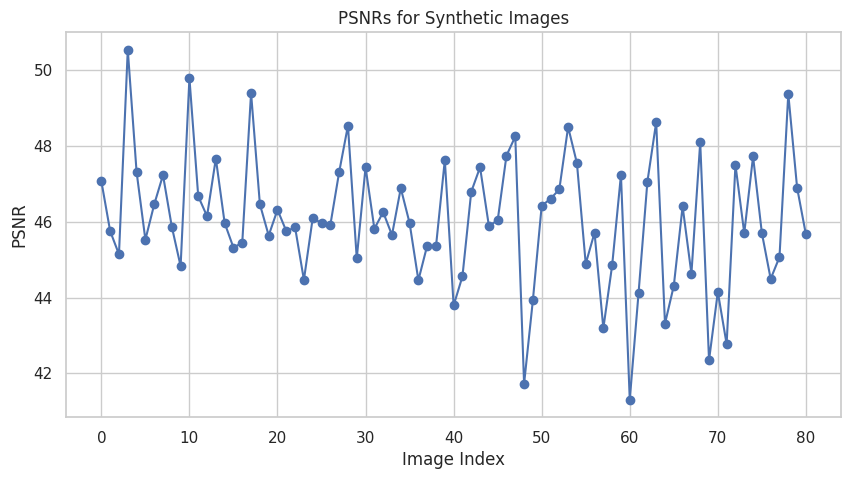

In [ ]:
# Plotting PSNRs
plt.figure(figsize=(10, 5))
plt.plot(psnrs, marker='o', linestyle='-', color='b')
plt.title('PSNRs for Synthetic Images')
plt.xlabel('Image Index')
plt.ylabel('PSNR')
plt.grid(True)
plt.show()


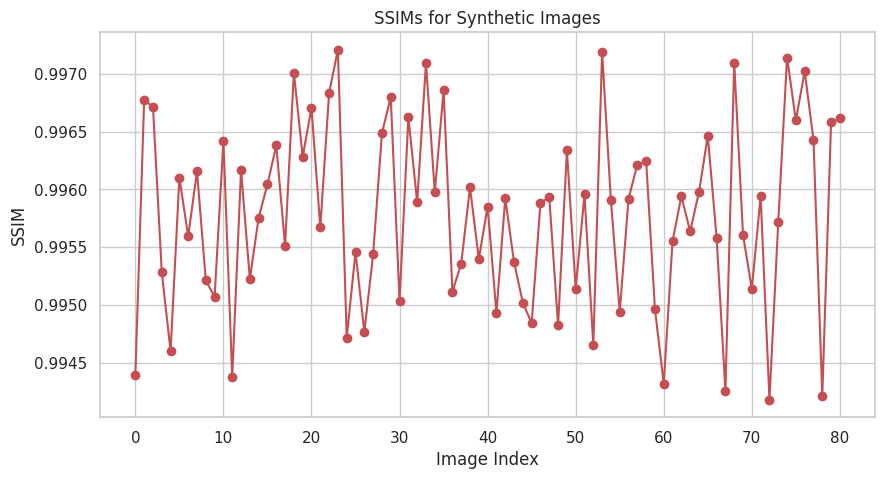

In [ ]:
# Plotting SSIMs
plt.figure(figsize=(10, 5))
plt.plot(ssims, marker='o', linestyle='-', color='r')
plt.title('SSIMs for Synthetic Images')
plt.xlabel('Image Index')
plt.ylabel('SSIM')
plt.grid(True)
plt.show()

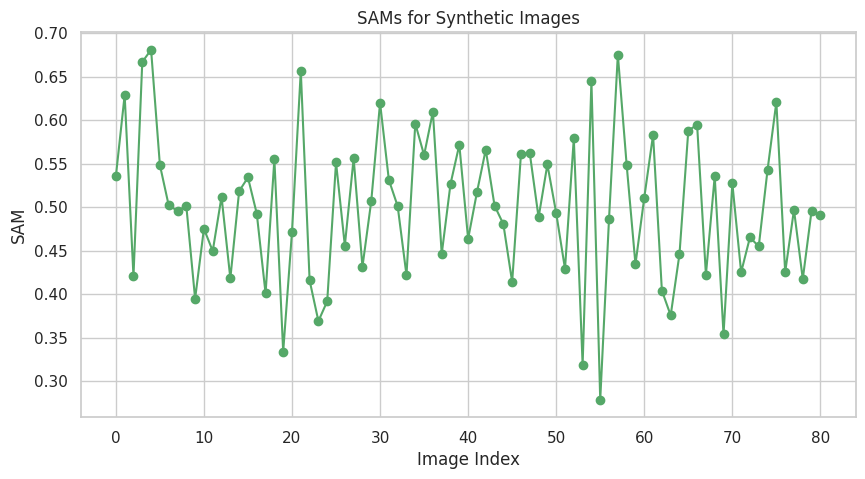

In [ ]:
# Plotting SAMs
plt.figure(figsize=(10, 5))
plt.plot(sams, marker='o', linestyle='-', color='g')
plt.title('SAMs for Synthetic Images')
plt.xlabel('Image Index')
plt.ylabel('SAM')
plt.grid(True)
plt.show()

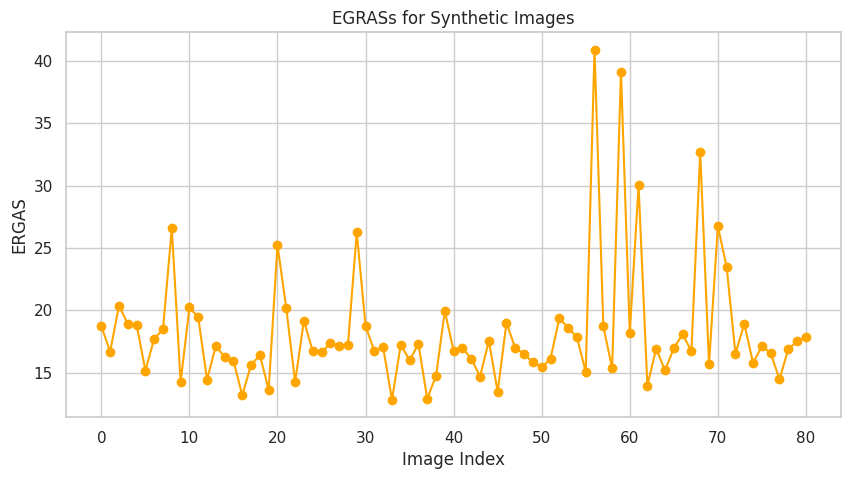

In [ ]:
# Plotting EGRASs
plt.figure(figsize=(10, 5))
plt.plot(ergass, marker='o', linestyle='-', color='orange')
plt.title('EGRASs for Synthetic Images')
plt.xlabel('Image Index')
plt.ylabel('ERGAS')
plt.grid(True)
plt.show()